In [19]:
#import 
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import pandas as pd
from datetime import datetime
import warnings
warnings.simplefilter('ignore')

In [17]:
def plot(path_to_tiff):
    """
    ## plot tiff image of band[0]
    args:
        path_to_tiff(str) : path to the tiff file exist
    returns:
        None (plot only)
    """
    tiff = gdal.Open(path_to_tiff) #水域以外には0が入っている
    tiff_array = tiff.ReadAsArray()
    #print(f"shape={tiff_array.shape}",path_to_tiff)
    plt.imshow(tiff_array[0,:,:])
    plt.colorbar()
    plt.suptitle(path_to_tiff[-9:-4])
    #plt.savefig(f"../png/tiff/{path_to_tiff[-9:-4]}.png")

In [20]:
def writeMergeShell(path_to_tiff_all,year = "2019",outputDirectory="../dat_satellite/merged"):
    """
    Write shell script that conduct merging of tiff images in the same day.
    args:
        path_to_tiff_all(list) : path to the tiff file you want to merge
        year(optional) : forcusing year
        outputDirectory : The directory you want to put your result
    returns:
        write file, the name is merge.sh 
    """
    # 日付の列の用意 mm-ddの形
    date_array = pd.date_range(start=year + '-01-01', periods=365, freq='D')
    date_array_month_and_day = [d.strftime("%m-%d") for d in date_array]

    # ファイル書き込みのスタート
    with open("./merge.sh",mode = "w") as f:

        #sh スクリプトに絶対必要な文言
        f.write("#!/bin/bash \n")
        f.write(". '/home/k-ishida/miniconda3/etc/profile.d/conda.sh'\n")
        f.write("conda activate gdal \n")
        #ディレクトリのクリア(gdal_merge.pyは上書きをしてくれないため)
        f.write(f"rm -rf {outputDirectory} /*\n")

        #画像がある日付のみを抽出
        for date in date_array_month_and_day:
            matchImage = []
            valueList = []
            pathList = []

            # その日付を含むpathを全て抽出
            for path in path_to_tiff_all:
                if "2019-"+date in path and "(" not in path:
                    #範囲が異なる二枚を合成しないとバグるので、時刻のminとmaxの二枚だけ抽出する
                    value = int(path[-6:-5]) + int(path[-9:-8]) * 60 
                    valueList.append(value)
                    pathList.append(path)
            if valueList != []:
                maximum_index = valueList.index(max(valueList))
                minimum_index = valueList.index(min(valueList))
                matchImage.append(pathList[maximum_index])
                matchImage.append(pathList[minimum_index])

                #書き出しの開始
                outputFileName = f"{outputDirectory}/S2L2A_SL_merged_"+date+".tif"
                f.write(f"gdal_merge.py -o {outputFileName} -ot Float32 -co COMPRESS=LZW -n 0 {' '.join(map(str, matchImage))} \n")
                f.write(f"echo '{outputFileName} is created.'\n")

    print("Finish writing merge.sh")
    #実行権限を付与
    !chmod 755 merge.sh
    print("start merging")
    return 

In [35]:
path_to_tiff_all = glob("../dat_satellite/S2L2A_SL_2019_B8A/S2L2A_Mississippi_2019-*.tif")
writeMergeShell(path_to_tiff_all,outputDirectory="../dat_satellite/merged_wide")

Finish writing merge.sh
start merging


In [29]:
path_to_tiff = glob("../dat_satellite/merged/*.tif")
print(path_to_tiff)
from concurrent import futures
import os
with futures.ProcessPoolExecutor(os.cpu_count()-2) as executor:
    for path in path_to_tiff:
        future = executor.submit(plot,path)

['../dat_satellite/merged/S2L2A_SL_merged_05-24.tif', '../dat_satellite/merged/S2L2A_SL_merged_08-09.tif', '../dat_satellite/merged/S2L2A_SL_merged_07-23.tif', '../dat_satellite/merged/S2L2A_SL_merged_07-18.tif', '../dat_satellite/merged/S2L2A_SL_merged_08-19.tif', '../dat_satellite/merged/S2L2A_SL_merged_06-28.tif', '../dat_satellite/merged/S2L2A_SL_merged_12-05.tif', '../dat_satellite/merged/S2L2A_SL_merged_10-13.tif', '../dat_satellite/merged/S2L2A_SL_merged_07-08.tif', '../dat_satellite/merged/S2L2A_SL_merged_07-10.tif', '../dat_satellite/merged/S2L2A_SL_merged_01-09.tif', '../dat_satellite/merged/S2L2A_SL_merged_04-21.tif', '../dat_satellite/merged/S2L2A_SL_merged_06-05.tif', '../dat_satellite/merged/S2L2A_SL_merged_04-26.tif', '../dat_satellite/merged/S2L2A_SL_merged_11-10.tif', '../dat_satellite/merged/S2L2A_SL_merged_09-26.tif', '../dat_satellite/merged/S2L2A_SL_merged_06-30.tif', '../dat_satellite/merged/S2L2A_SL_merged_07-25.tif', '../dat_satellite/merged/S2L2A_SL_merged_10-0

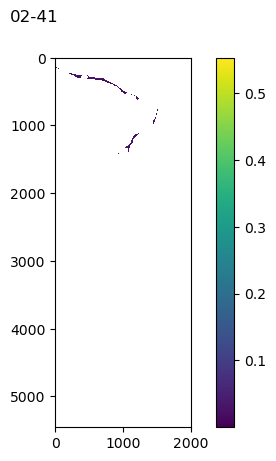

In [18]:
path_to_tiff = "../dat_satellite/S2L2A_SL_2019_B8A/S2L2A_2019-01-09-05-02-41.tif"
plot(path_to_tiff)